In [55]:
import torch
import numpy as np
import json
from torch.nn import LSTM
from torch.utils.data import DataLoader, IterableDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
import pickle
import os
from seqeval.scheme import IOB2
from seqeval.metrics import accuracy_score, f1_score

In [56]:
#!git clone https://github.com/SapienzaNLP/nlp2023-hw1/tree/main/data.git

In [57]:
class TextDataset(torch.utils.data.Dataset):
  def __init__(self, file):
    self.tokens, self.labels = [], []
    self.data = {}
    with open(file) as f:
      for line in f:
        self.data = json.loads(line)
        # Lower case the tokens 
        lower_toks = [item.lower() for item in self.data["tokens"]]
        self.tokens.append(lower_toks)
        self.labels.append(self.data["labels"])
    
  def __getitem__(self, idx):
        return {'tokens': self.tokens[idx], 'labels': self.labels[idx]}

  def __len__(self):
        return len(self.data)

  @staticmethod
  def decode_output(outputs, label_vocab):
        top_label_scores, top_label_indices = torch.max(outputs, -1) 
        list_of = list(zip(map(lambda x: x.item(), top_label_indices), map(lambda x: x.item(), top_label_scores)))
        predictions = []   
        for i in range(len(list_of)):
          predictions.append(label_vocab[list_of[i][0]])
        return predictions

In [58]:
# Loading the train dataset  
datapath_train_temp = os.path.abspath('Event-Detection/data/train.jsonl')
datapath_train = datapath_train_temp.replace("Event-Detection/hw1/stud/", "")
train_dataset = TextDataset(datapath_train)

In [59]:
# Loading the test dataset  
datapath_test_temp = os.path.abspath('Event-Detection/data/test.jsonl')
datapath_test = datapath_test_temp.replace("Event-Detection/hw1/stud/", "")
test_dataset = TextDataset(datapath_test)

In [60]:
train_sentences = []
for i in range(20000):
  train_sentences.append(train_dataset[i]['tokens'])
vocab = list(dict.fromkeys(sum(train_sentences, [])))

test_sentences = []
for i in range(2000):
  test_sentences.append(test_dataset[i]['tokens'])

all_sentences = train_sentences + test_sentences

In [119]:
path_vocab_temp = os.path.abspath('Event-Detection/model/vocab.pkl')
path_vocab = path_vocab_temp.replace("Event-Detection/hw1/stud/", "")

def save_vocab(vocab):
    output = open(path_vocab, 'wb')
    pickle.dump(vocab, output)
    output.close()
save_vocab(vocab)

In [62]:
# Downloading the glove zip file
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [63]:
# Unziping it
!unzip glove.6B.zip

In [64]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [65]:
def find_unknown_words(words):  
    unknown_words = []    
    for word in words:
        if not (word in embeddings_index):
            unknown_words.append(word)
    return words

In [66]:
unknown_train_words = find_unknown_words(vocab)
print( f'{len(unknown_train_words)/len(vocab)}% of training words are unknown' )

1.0% of training words are unknown


In [67]:
def assign_index(sentences):
  word_to_ix = {}
  for sentence in sentences:
    for token in sentence:
      if token not in word_to_ix:
          word_to_ix[token] = len(word_to_ix)
  return word_to_ix
  
word_to_ix = assign_index(all_sentences)

In [68]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [69]:
def embd(sentence):
  emb_sentence = []
  for word in sentence :
    if word in embeddings_index :
      word = embeddings_index[word]
      emb_sentence.append(word)
    else :
      # Assigning the same embedding of 'the' to unknown tokens
      word = embeddings_index['the']
      emb_sentence.append(word)
  return emb_sentence

In [70]:
class LSTM_ED(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        super(LSTM_ED, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.tagset_size = tagset_size
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, bidirectional=False, dropout=0)  
        self.classifier = nn.Linear(self.hidden_dim, self.tagset_size)

    def forward(self, sentence):
        embeds = embd(sentence)
        embeds_t = torch.tensor(np.array(embeds), dtype=torch.float32)
        lstm_out, _ = self.lstm(embeds_t.view(len(sentence), 1, self.embedding_dim))
        tag_space = self.classifier(lstm_out.view(len(sentence), -1))
        return tag_space

In [71]:
labels = ['B-SENTIMENT', 'I-SENTIMENT',
             'B-SCENARIO', 'I-SCENARIO',
             'B-CHANGE', 'I-CHANGE',
             'B-POSSESSION', 'I-POSSESSION',
             'B-ACTION', 'I-ACTION',
             'O']

tag_to_ix = {0:"B-SENTIMENT", 1:"I-SENTIMENT",
             2:"B-SCENARIO", 3:"I-SCENARIO",
             4:"B-CHANGE", 5:"I-CHANGE", 
             6:"B-POSSESSION", 7:"I-POSSESSION",
             8:"B-ACTION", 9:"I-ACTION",
             10:"O"}

inverse_tag_to_ix = {"B-SENTIMENT":0, "I-SENTIMENT":1,
                      "B-SCENARIO":2, "I-SCENARIO":3,
                      "B-CHANGE":4, "I-CHANGE":5,
                      "B-POSSESSION":6, "I-POSSESSION":7,
                      "B-ACTION":8, "I-ACTION":9,
                      "O":10}

nb_tags = 11

In [95]:
lstm_model = LSTM_ED(100, 300, nb_tags)

In [96]:
class Trainer():
  def __init__(self, model):
    self.model = model
    self.weights = torch.tensor([0.095, 0.095, 0.095, 0.095, 0.095, 0.095, 0.095, 0.095, 0.095, 0.095, 0.05])
    self.loss_fct = nn.CrossEntropyLoss(weight=self.weights)
    self.optimizer = optim.Adam(lstm_model.parameters(), lr=0.1)

  def train(self, train_dataset, epochs):
      batch_counter = 0
      batch_size = 1000
      train_losses = []
      for epoch in range(epochs):
        
        print("")
        print("epoch", epoch)

        self.model.train()
        epoch_loss = 0
        for i in range(batch_counter, batch_size+batch_counter):
          self.optimizer.zero_grad()
          input = train_dataset[i]['tokens']  
          logit = self.model(input)
          encoded_labels = prepare_sequence(train_dataset[i]['labels'], inverse_tag_to_ix)          
          loss = self.loss_fct(logit, encoded_labels)          
          epoch_loss += loss
          loss.backward()
          self.optimizer.step()
          
        print(epoch_loss/batch_size)
        
        train_losses.append(epoch_loss/batch_size)
        batch_counter += 1000
        if epoch % 20 == 0:
          batch_counter = 0
      return train_losses

  def evaluate(self, test_dataset):
        test_losses = []
        self.model.eval()
        with torch.no_grad():
            for i in range(2000):
                input = test_dataset[i]['tokens']
                logit = self.model(input) 
                encoded_labels = prepare_sequence(test_dataset[i]['labels'], inverse_tag_to_ix)            
                sample_loss = self.loss_fct(logit, encoded_labels)
                test_losses.append(sample_loss)
        return test_losses

In [97]:
trainer = Trainer(
    model = lstm_model
)

In [99]:
train_losses = trainer.train(train_dataset, 60)


epoch 0
tensor(0.7707, grad_fn=<DivBackward0>)

epoch 1
tensor(0.7758, grad_fn=<DivBackward0>)

epoch 2
tensor(0.7692, grad_fn=<DivBackward0>)

epoch 3
tensor(0.7880, grad_fn=<DivBackward0>)

epoch 4
tensor(0.7466, grad_fn=<DivBackward0>)

epoch 5
tensor(0.7588, grad_fn=<DivBackward0>)

epoch 6
tensor(0.7394, grad_fn=<DivBackward0>)

epoch 7
tensor(0.7245, grad_fn=<DivBackward0>)

epoch 8
tensor(0.6789, grad_fn=<DivBackward0>)

epoch 9
tensor(0.6839, grad_fn=<DivBackward0>)

epoch 10
tensor(0.6792, grad_fn=<DivBackward0>)

epoch 11
tensor(0.6830, grad_fn=<DivBackward0>)

epoch 12
tensor(0.7255, grad_fn=<DivBackward0>)

epoch 13
tensor(0.6507, grad_fn=<DivBackward0>)

epoch 14
tensor(0.6113, grad_fn=<DivBackward0>)

epoch 15
tensor(0.6335, grad_fn=<DivBackward0>)

epoch 16
tensor(0.6080, grad_fn=<DivBackward0>)

epoch 17
tensor(0.6475, grad_fn=<DivBackward0>)

epoch 18
tensor(0.6127, grad_fn=<DivBackward0>)

epoch 19
tensor(0.6488, grad_fn=<DivBackward0>)

epoch 20
tensor(0.6460, grad_

In [100]:
av_tr_loss = 0
for i in range(len(train_losses)):
  av_tr_loss += train_losses[i].item()

print(av_tr_loss/len(train_losses))

0.627978586157163


In [108]:
test_losses = trainer.evaluate(test_dataset)

In [112]:
av_test_loss = 0
for i in range(2000):
  av_test_loss += test_losses[i].item()

print(av_test_loss/2000)

0.5216010042469424


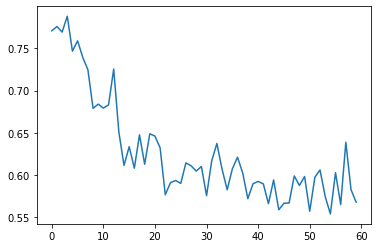

In [107]:
epoch_count = range(0, 60)
tr_losses = [x.detach().numpy() for x in train_losses]
plt.plot(epoch_count, tr_losses)

In [117]:
path_model_temp = os.path.abspath('nlp2023-hw1/model/model_100d_60e_bis_bis.pth')
path_model = path_model_temp.replace("nlp2023-hw1/hw1/stud/", "")
torch.save({
            'model_state_dict': lstm_model.state_dict(),
            'test_loss': av_test_loss/2000,
            'train_loss': av_tr_loss/len(train_losses)
            }, path_model)

In [104]:
# Unbalanced dataset analysis 
counter_labels = 0
counter_O = 0

for i in range(20000):
  encoded_labels = prepare_sequence(train_dataset[i]['labels'], inverse_tag_to_ix)
  for j in range(len(encoded_labels)):
    counter_labels += 1
    if encoded_labels[j] == 10: # 10 corresponding to 'O'
      counter_O += 1

print("Percentage of 'O' labels: ", (counter_O/counter_labels)*100)		

Percentage of 'O' labels:  90.3573134706691


PERFORMANCE

In [105]:
def F1(model, l_dataset):
    all_predictions = []
    all_labels = []
    for i in range(2000):
        indexed_in = l_dataset[i]['tokens']
        indexed_labels = l_dataset[i]['labels']
        logit = model(indexed_in)
        predictions = l_dataset.decode_output(logit, tag_to_ix)
        #all_predictions += predictions
        #all_labels += indexed_labels
        all_predictions.append(predictions)
        all_labels.append(indexed_labels)
    
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', mode="strict", scheme=IOB2, zero_division=0)
    weighted_f1 = f1_score(all_labels, all_predictions, average='weighted', mode="strict", scheme=IOB2)
    accuracy = accuracy_score(all_labels, all_predictions)
    return macro_f1, weighted_f1, accuracy

In [111]:
macro, weighted, acc = F1(lstm_model, test_dataset)

print("Macro_F1: ", macro)
print("Weighted_F1: ", weighted)
print("Accuracy: ", acc)

Macro_F1:  0.3278940100202021
Weighted_F1:  0.3803454888602671
Accuracy:  0.8989172467130704


Confusion matrix

In [113]:
def confusion_mat(model, l_dataset, l_label_vocab):
    all_predictions = []
    all_labels = []
    for i in range(2000):
        indexed_in = l_dataset[i]['tokens']
        indexed_labels = l_dataset[i]['labels'] 
        logit = model(indexed_in)
        predictions = l_dataset.decode_output(logit, tag_to_ix)
        all_predictions += predictions
        all_labels += indexed_labels
  
    cm = confusion_matrix(all_labels, all_predictions, labels=labels)

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

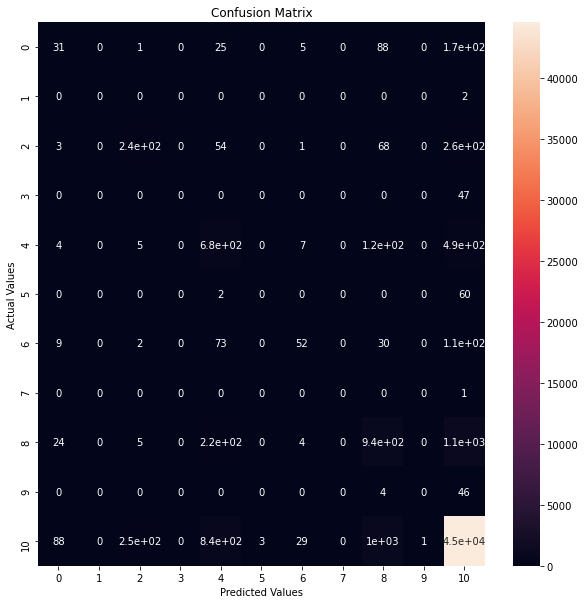

In [114]:
confusion_mat(lstm_model, test_dataset, tag_to_ix)